In [70]:

import xarray as xr
import rioxarray 
from pathlib import Path
import pandas as pd
import numpy as np
import random

In [71]:
"""
to install all of the libraries, use the command
!pip install (name)
ex. 
!pip install xarray
"""

'\nto install all of the libraries, use the command\n!pip install (name)\nex. \n!pip install xarray\n'

In [72]:
"""
Get Array of a Certain Country
#get_bounding_box_max_min_lat_long_values -> gets country data using the country name

the other methods are helper methods

To run the code yourself and generate your own masks,you just have to change this line:
pd.read_csv('/Users/kevinha/VYPREarth/UNET_implementation/country-boundingboxes.csv')

Change the file location to the file location you used
"""

"\nGet Array of a Certain Country\n#get_bounding_box_max_min_lat_long_values -> gets country data using the country name\n\nthe other methods are helper methods\n\nTo run the code yourself and generate your own masks,you just have to change this line:\npd.read_csv('/Users/kevinha/VYPREarth/UNET_implementation/country-boundingboxes.csv')\n\nChange the file location to the file location you used\n"

In [73]:

def get_bounding_box_max_min_lat_long_values(country_name, df_bounding_boxes):
    # Get min of lat and long for the country
    min_long = df_bounding_boxes[df_bounding_boxes['country'] == country_name]['longmin']
    min_lat = df_bounding_boxes[df_bounding_boxes['country'] == country_name]['latmin']
    # Get max of lat and long for the country
    max_long = df_bounding_boxes[df_bounding_boxes['country'] == country_name]['longmax']
    max_lat = df_bounding_boxes[df_bounding_boxes['country'] == country_name]['latmax']
    return  min_long, min_lat, max_long, max_lat

def get_location_names():
    df_bounding_boxes = pd.read_csv('/Users/kevinha/VYPREarth/UNET_implementation/country-boundingboxes.csv')
    country_names_list = df_bounding_boxes['country'].to_list()
    return country_names_list, df_bounding_boxes

def get_clipped_xarray_dataset(ds, country_name, df_bounding_boxes):
    # CRS code 
    dsc = ds.rio.write_crs(4326) # Need to specify this as Ilektra mentioned 
    
    # Get min of lat and long for the country  and  max of lat and long for the country
    min_long, min_lat, max_long, max_lat = get_bounding_box_max_min_lat_long_values(country_name, df_bounding_boxes)
    
    # Clip the dataset
    ds_clipped = dsc.rio.clip_box(minx= min_long, miny= min_lat, maxx= max_long,maxy= max_lat)
    
    return ds_clipped 


In [74]:
#get seasfire cube
ds=xr.open_zarr('/Users/kevinha/Downloads/seasfirecube.zarr')

/var/folders/fd/c30byq417d3dh1ystdk504100000gp/T/ipykernel_63694/2755374803.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds=xr.open_zarr('/Users/kevinha/Downloads/seasfirecube.zarr')


In [75]:
country_names_list, df_bounding_boxes = get_location_names()
ds_clipped=get_clipped_xarray_dataset(ds,'Burma', df_bounding_boxes)

In [76]:
#dimensions of country data, they have 90 latitude units and 40 longitude units over 966 time snapshots
ds_clipped.dims

Frozen({'latitude': 90, 'longitude': 41, 'time': 966})

In [77]:
#image_dataset=ds_clipped.sel(cols=['LST_Day_CMG','NDVI','mslp','ssr','t2mmin','tp','vpd_cf','BurntArea'])

In [78]:
#convert to numpy array
image_dataset = np.array(ds_clipped.to_array())

In [79]:
#dimensions of numpy array(35 variables, 966 time snapshots, 90 latitude units, 41 longitude units)
image_dataset.shape

(35, 966, 90, 41)

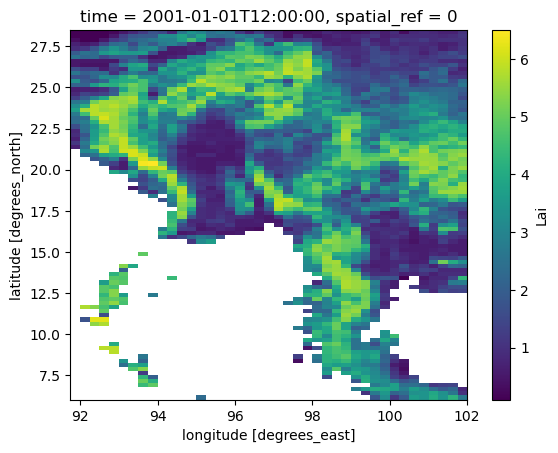

In [80]:
#picture of a leaf area plot
ds_clipped['Lai'].isel(time=0).plot()

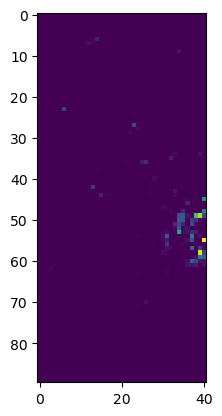

In [81]:
#plot Burnt Area grid at time 0(90*41 grid)
from matplotlib import pyplot as plt
plt.imshow(image_dataset[0][0])

In [82]:
#extract the 9 features(variables) we want from the seasfire cube
#these numbers are the indexes of the variables in the seasfire cube
image_dataset=image_dataset[[1,5,7,15,24,27,30,21,32]]

In [83]:
image_dataset.shape

(9, 966, 90, 41)

In [84]:
#burntarea:1 , land surface temperature =5, vegatation =7, mslp: 15, solar radiation: 24, ssv1: 27, temperature min:30, total precipitation: 31, vpd_cf:32
#mslp, vpd_cf, ssvl showed minor correlations with burned area becasue they deal with precipitation and soil content

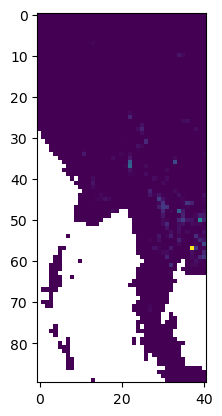

In [85]:
plt.imshow(image_dataset[0][2])

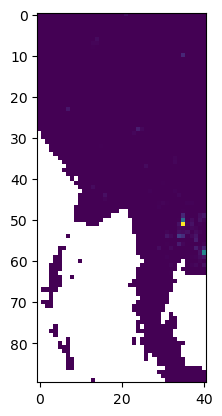

In [86]:

from matplotlib import pyplot as plt
plt.imshow(image_dataset[0][0])

In [87]:
#reformat images into new shape
images=[]
masks=[]
for i in range(0, 966):
    if(i%2==0):
        images.append(image_dataset[:,i,:,:])
    else:
        masks.append(image_dataset[:,i,:,:])
                    

In [88]:
#since UNET requires the size of the image to be divisible by 32, this code cuts out a 32*32 square from the image
#it also separates the data into three classes: Burntarea<1000, 1000<BurntArea<100000, and BurntArea>100000, these are used as the masks
latStart=30
latEnd=62
longStart=8
longEnd=40
for i in range(0,483):
    ba=False
    for j in range(latStart,latEnd):
        for k in range(longStart,longEnd):
            if(masks[i][0][j][k]>10000):
                masks[i][0][j][k]=2
            elif(masks[i][0][j][k]>1000):
                masks[i][0][j][k]=1
            else:
                masks[i][0][j][k]=0
   

In [89]:
#delete images with no BurntArea pixels, we only care about places with wildfires
deletes=[]
for i in range(0,483):
    ba=False
    for j in range(latStart,latEnd):
        for k in range(longStart,longEnd):
            if(images[i][0][j][k]>0):
                ba=True
    if ba==False:
        deletes.append(i)

In [90]:
#changing shape of arrays again to fit UNET
modified_images=[]
modified_masks=[]
for i in range(0,483):
    temp_image=[]
    temp_mask=[]
    for x in range(latStart,latEnd):
        temp_image_row=[]
        temp_mask_row=[]
        for y in range(longStart,longEnd):
            temp_image_pixel=[]
            temp_mask_pixel=[]
            for j in range(0,8):
                temp_image_pixel_feature=images[i][j][x][y]
                temp_image_pixel.append(temp_image_pixel_feature)
                
            temp_mask_pixel_feature=masks[i][0][x][y]
            temp_mask_pixel.append(temp_mask_pixel_feature)
                
            temp_image_row.append(temp_image_pixel)
            temp_mask_row.append(temp_mask_pixel)
            
        temp_image.append(temp_image_row)
        temp_mask.append(temp_mask_row)
        
    modified_images.append(temp_image)
    modified_masks.append(temp_mask)
                
    

In [91]:
images=np.asarray(modified_images)
masks=np.asarray(modified_masks)

In [92]:

images=np.delete(images, deletes, 0)


In [93]:
images.shape

(227, 32, 32, 8)

In [94]:
masks=np.delete(masks, deletes,0)
masks.shape

(227, 32, 32, 1)

In [95]:
#one-hot encoding masks(need this for multiclass segmentation)
modified_masks_cat=[]
sz=483-len(deletes)
for i in range(0,sz):
    one_time=[]
    for j in range(0,32):
        one_row=[]
        for k in range(0,32):
            if(masks[i][j][k][0]==0):
                one_row.append([1.0,0.0,0.0])
            elif(masks[i][j][k][0]==1):
                one_row.append([0.0,1.0,0.0])
            else:
                one_row.append([0.0,0.0,1.0])
        one_time.append(one_row)
    modified_masks_cat.append(one_time)


In [96]:
masks=np.asarray(modified_masks_cat)
masks.shape

(227, 32, 32, 3)

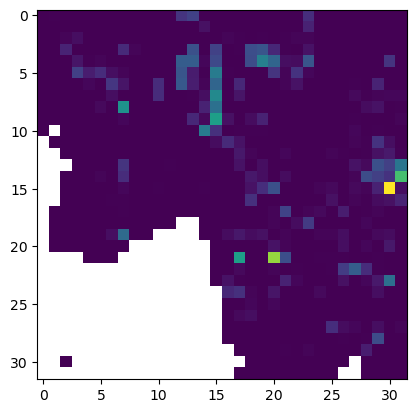

In [97]:
plt.imshow(images[16,:,:,0])

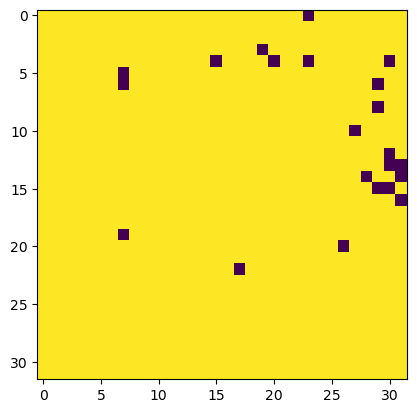

In [98]:
plt.imshow(masks[16,:,:,0])

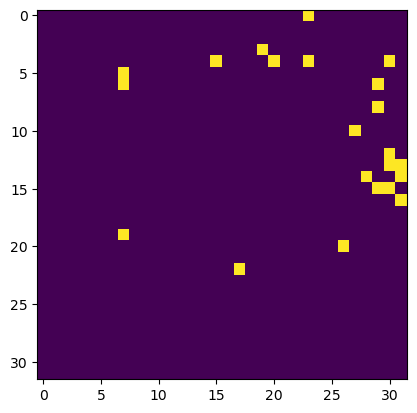

In [99]:
plt.imshow(masks[16,:,:,1])

In [100]:
from scipy import stats
#normalizing the data
for i in range(0,sz):
    for j in range(0,8):
        images[np.isnan(images)] = 0
        images[i,:,:,j]=stats.zscore(images[i,:,:,j])
        

In [101]:
#checking the types of the image and masks datasets
images.dtype

dtype('float32')

In [102]:
masks.dtype

dtype('float64')

In [103]:
images = images.astype(float)

In [104]:
images.dtype

dtype('float64')

In [105]:
masks=masks.astype(float)

In [106]:
images.shape

(227, 32, 32, 8)

In [107]:
masks.shape

(227, 32, 32, 3)

In [108]:
#!pip install tensorflow

#!pip install keras
#!pip install -U --pre segmentation-models

#install this stuff to run the model

In [109]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [110]:
def multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs=Input((IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS))
    s=inputs
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    #c9 = Dropout(0.2)(c9)  # Original 0.1
    #c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model
    

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(images, masks, test_size=0.205, random_state=42)

In [112]:
y_train.shape

(180, 32, 32, 3)

In [113]:
X_train.shape

(180, 32, 32, 8)

In [114]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
 
#IMG_HEIGHT = 32
#IMG_WIDTH  = 32
#IMG_CHANNELS = 9

#the jacard coefficient measures the overlap between the predicted wildfire areas and actual wildfire areas
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)
metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=3, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
#model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 8)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 32, 32, 16)   1168        ['input_2[0][0]']                
                                                                                                  
 dropout_8 (Dropout)            (None, 32, 32, 16)   0           ['conv2d_18[0][0]']              
                                                                                                  
 conv2d_19 (Conv2D)             (None, 32, 32, 16)   2320        ['dropout_8[0][0]']              
                                                                                            

In [115]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 5, 
                    verbose=1, 
                    epochs=10, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/10
36/36 [==============================] - 4s 54ms/step - loss: 0.2759 - accuracy: 0.8942 - jacard_coef: 0.8032 - val_loss: 0.1163 - val_accuracy: 0.9791 - val_jacard_coef: 0.9450
Epoch 2/10
36/36 [==============================] - 2s 48ms/step - loss: 0.0669 - accuracy: 0.9880 - jacard_coef: 0.9503 - val_loss: 0.0878 - val_accuracy: 0.9791 - val_jacard_coef: 0.9269
Epoch 3/10
36/36 [==============================] - 2s 44ms/step - loss: 0.0560 - accuracy: 0.9880 - jacard_coef: 0.9557 - val_loss: 0.0791 - val_accuracy: 0.9791 - val_jacard_coef: 0.9303
Epoch 4/10
36/36 [==============================] - 2s 47ms/step - loss: 0.0511 - accuracy: 0.9880 - jacard_coef: 0.9577 - val_loss: 0.0758 - val_accuracy: 0.9791 - val_jacard_coef: 0.9260
Epoch 5/10
36/36 [==============================] - 2s 47ms/step - loss: 0.0481 - accuracy: 0.9880 - jacard_coef: 0.9588 - val_loss: 0.0715 - val_accuracy: 0.9791 - val_jacard_coef: 0.9327
Epoch 6/10
36/36 [==============================] - 2s 

In [116]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [117]:
y_pred=model.predict(X_test)
np.unique(y_pred, return_counts=True)

2/2 [==============================] - 0s 18ms/step


(array([0.0000000e+00, 1.3514338e-38, 1.5768793e-38, ..., 9.9999970e-01,
        9.9999982e-01, 9.9999994e-01], dtype=float32),
 array([  44,    1,    1, ...,  456,  880, 3242]))

1/1 [==============================] - 0s 24ms/step


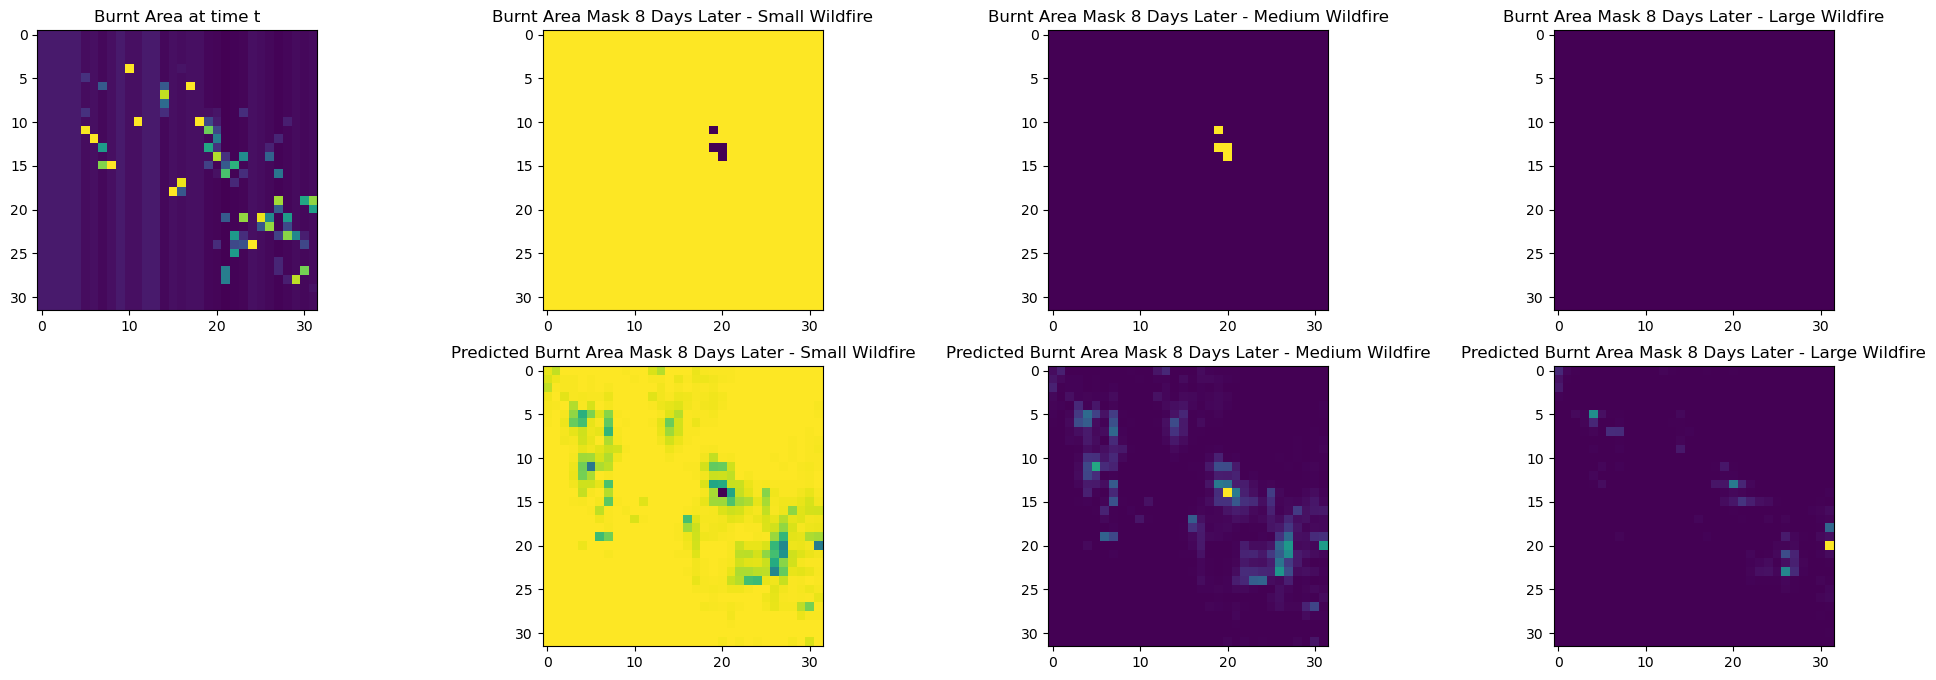

In [123]:
#generate predictions of random wildfires and display them, you can run this box as much as you want to keep generating masks
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
np.unique(prediction, return_counts=True)
predicted_img=prediction[0,:,:]
plt.figure(figsize=(25, 8))
plt.subplot(241)
plt.title('Burnt Area at time t')
plt.imshow(test_img[:,:,0])
plt.subplot(242)
plt.title('Burnt Area Mask 8 Days Later - Small Wildfire')
plt.imshow(ground_truth[:,:,0])
plt.subplot(246)
plt.title('Predicted Burnt Area Mask 8 Days Later - Small Wildfire')
plt.imshow(predicted_img[:,:,0])
plt.subplot(243)
plt.title('Burnt Area Mask 8 Days Later - Medium Wildfire')
plt.imshow(ground_truth[:,:,1])
plt.subplot(247)
plt.title('Predicted Burnt Area Mask 8 Days Later - Medium Wildfire')
plt.imshow(predicted_img[:,:,1])
plt.subplot(244)
plt.title('Burnt Area Mask 8 Days Later - Large Wildfire')
plt.imshow(ground_truth[:,:,2])
plt.subplot(248)
plt.title('Predicted Burnt Area Mask 8 Days Later - Large Wildfire')
plt.imshow(predicted_img[:,:,2])
plt.show()

